# Project 1
## Team members:
### Nguyen N
### Brandon H
### Jennifer M
### Sam Y

In [1]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import numpy as np
from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC # for problem 3

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score # recall scorer
from sklearn.metrics import precision_score # precision scorer
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import f1_score # f1

import nltk
from nltk import pos_tag

import itertools

nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import pandas as pd


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jennifermacdonald/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jennifermacdonald/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jennifermacdonald/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Helper Methods

In [2]:
# I make histogram
def plot_histogram(dataset_target, dataset_target_names):
    number_of_documents = []

    for i in range(len(dataset_target_names)):
        number_of_documents.append(len([x for x in dataset_target if x == i]))

    #plot histogram
    x_labels = dataset_target_names
    fig, ax = plt.subplots()
    ax.set_xticks([i+0.35 for i in range(1,9)])
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize = 12)

    rects = plt.bar([i for i in range(1,9)], number_of_documents, align='edge')
    plt.xlabel('Topics', fontsize = 14)
    plt.ylabel('Number of Documents', fontsize = 14)
    plt.title('Number of documents per topic ', fontsize = 18)
    plt.axis([0.5,9,0,1100])

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%d' % int(height), ha='center', va='bottom')
    print('Length: ' + str(len(dataset_target)))
    plt.show()

       
# I morph stuff.
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

# I lematize stuff.
def lemmatize_parse(text):
    wnl = nltk.wordnet.WordNetLemmatizer()
    lemmatize = []
    for word, tag in pos_tag(nltk.word_tokenize(text)):
        if(word.isdigit() or word.isalpha()):
            lemmatize.append(wnl.lemmatize(word.lower(), pos=penn2morphy(tag)))
    return lemmatize


# Oh look, I can make confusion matrix
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          classes = ['Computer\n Technology', 'Recreational\n Activity']
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Just using this for logistic regression part, maybe will be useful for other parts too (not using pipes)
def roc_plotter(model, data, labels):
    scores = model.decision_function(data)
    fpr, tpr, thresholds = metrics.roc_curve(labels,scores,pos_label=1)
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
def predict_and_plot_svc(train_set, test_set, binary_train_target, binary_test_target, gamma):
    svc = svm.SVC(gamma = gamma, probability=True)
    svc.fit(train_set, binary_train_target)
    svc_predicted = svc.predict(test_set)

    print('gamma: '+ str(gamma))
    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), svc_predicted)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), svc_predicted)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), svc_predicted)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), svc_predicted)))
    
    #compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(binary_test_target, svc_predicted)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
    plt.show()
    
    # ROC curve
    print('ROC curve')
    roc_plotter(svc,test_set,binary_test_target) 

def predict_calculate_svc(train_set, test_set, binary_train_target, binary_test_target, gamma):
    plt.gcf().clear()
    svc = svm.SVC(gamma = gamma, probability=True)
    svc.fit(train_set, binary_train_target)
    svc_predicted = svc.predict(test_set)

    print('gamma: '+ str(gamma))
    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), svc_predicted)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), svc_predicted)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), svc_predicted)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), svc_predicted)))
    
    #compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(binary_test_target, svc_predicted)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
    plt.show() 
    
    # calculate fpr_tpr
    fpr, tpr = calculate_fpr_tpr(svc.decision_function(test_set), binary_test_target)
    return fpr, tpr


    
def calculate_fpr_tpr(prob_func, labels):
#     scores = model.decision_function(data)
    fpr, tpr, thresholds = metrics.roc_curve(labels,prob_func,pos_label=1)
    return fpr, tpr

def combined_roc_plotter(fprs, tprs, gammas, meths):
    plt.figure(figsize=(12,9))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC Curve', fontsize=23)
#     color = ['g', 'm', 'r', 'deepskyblue', 'darkorange', 'c']
#     df = [2, 2, 5, 5, 2, 2]
    for i in range(len(fprs)):
        plt.plot(fprs[i],tprs[i], label = 'ROC Curve: {meth} {gamma}'.format(meth=meths[i], gamma=gammas[i]) )
#         plt.plot(fprs[i], tprs[i], color=color[i], lw=2, label='ROC curve ('+meth[i]+', min_df='+str(df[i])+', gamma='+str(gamma[i])+')')
    plt.legend(loc="lower right")
    plt.show()
    
def predict_calculate_naive_bayes(train_set, test_set, binary_train_target, binary_test_target):
    plt.gcf().clear()
    gnb = GaussianNB()
    gnb.fit(train_set, binary_train_target)
    pred = gnb.predict(test_set)

    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), pred)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), pred)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), pred)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), pred)))
    
    #compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(binary_test_target, pred)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
    plt.show() 
    
    # calculate fpr_tpr
    fpr, tpr = calculate_fpr_tpr(gnb.predict_proba(test_set)[:,1], binary_test_target)
    return fpr, tpr


### QUESTION 1: To get started, plot a histogram of the number of training documents per category to check if they are evenly distributed.

In [3]:
computer_technology_subclasses = ['comp.graphics',
                                  'comp.os.ms-windows.misc',
                                  'comp.sys.ibm.pc.hardware',
                                  'comp.sys.mac.hardware']

recreational_activity_subclasses = ['rec.autos',
                                    'rec.motorcycles',
                                    'rec.sport.baseball',
                                    'rec.sport.hockey']

categories = computer_technology_subclasses + recreational_activity_subclasses

In [4]:
train_dataset = fetch_20newsgroups(subset='train', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))

test_dataset = fetch_20newsgroups(subset='test', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))




# comp_tech_train = fetch_20newsgroups(subset='train', categories=computer_technology_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers'))
# rec_act_train = fetch_20newsgroups(subset='train', categories=recreational_activity_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers'))
# comp_tech_test = fetch_20newsgroups(subset='test', categories=computer_technology_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers'))
# rec_act_test = fetch_20newsgroups(subset='test', categories=recreational_activity_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers'))


# train_target_names = data_dict['Computer Technology Train']['target_names'] + data_dict['Recreational Activity Train']['target_names']

# test_target = data_dict['Computer Technology Test']['target'] + data_dict['Recreational Activity Test']['target']
# test_target_names = data_dict['Computer Technology Test']['target_names'] + data_dict['Recreational Activity Test']['target_names']



# Turn Multiclass into Binary

In [5]:
binary_train_target = train_dataset.target.copy()
binary_test_target = test_dataset.target.copy()
computer_class_indices = [0,1,2,3]
recreational_class_indices = [4,5,6,7]

computer_class_label = 0
recreational_class_label = 1

# Binarize computer-class labels
for i in computer_class_indices:
    binary_train_target[binary_train_target == i] = computer_class_label
    binary_test_target[binary_test_target == i] = computer_class_label

# Binarize recreational-class labels
for i in recreational_class_indices:
    binary_train_target[binary_train_target==i] = recreational_class_label
    binary_test_target[binary_test_target == i] = recreational_class_label
 
print("Sanity Check!\n")
print("Training Set")
print("Original train_dataset.target: " + str(train_dataset.target[0:20]))
print("Binarized train_dataset.target:" + str(binary_train_target[0:20]))
print("\nTest Set")
print("Original test_dataset.target:  " + str(test_dataset.target[0:20]))
print("Binarized test_dataset.target: " + str(binary_test_target[0:20]))

Sanity Check!

Training Set
Original train_dataset.target: [6 7 4 2 1 3 0 7 5 3 0 5 5 5 3 1 3 0 0 2]
Binarized train_dataset.target:[1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0]

Test Set
Original test_dataset.target:  [3 2 3 3 2 3 2 6 0 1 0 1 7 7 1 5 7 2 0 1]
Binarized test_dataset.target: [0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0]


Train Dataset
Length: 4732


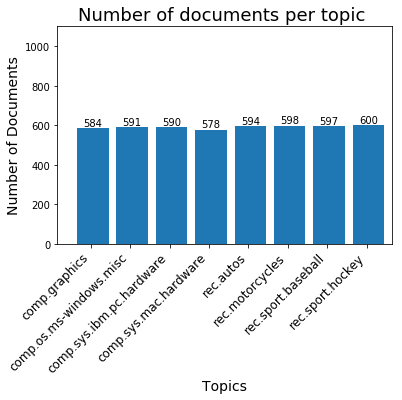

Test Dataset
Length: 3150


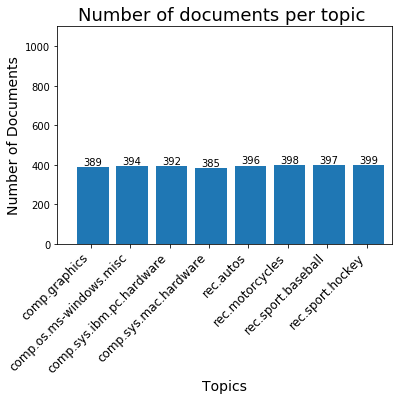

In [6]:
print('Train Dataset')
plot_histogram(train_dataset.target, train_dataset.target_names)

print('Test Dataset')
plot_histogram(test_dataset.target, test_dataset.target_names)

# Binary Classification

## Feature Extraction

### QUESTION 2: Use the following specs to extract features from the textual data:
#### • Use the default stopwords of the CountVectorizer
#### • Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
#### • Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
#### • Use min_df=3
### Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [7]:
# set lemmatize 
train_data_lemmatized = []
for item in train_dataset.data:
    train_data_lemmatized.append(' '.join(lemmatize_parse(item)))
    
test_dataset_lemmatized = []
for item in test_dataset.data:
    test_dataset_lemmatized.append(' '.join(lemmatize_parse(item)))
    
train_dataset.data = train_data_lemmatized
test_dataset.data = test_dataset_lemmatized

In [8]:
#Using TfidfVectorizer()
vectorizer = TfidfVectorizer(min_df = 3, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(train_dataset.data)
X_test_tfidf = vectorizer.transform(test_dataset.data)

In [9]:
print('X_train_tfidf:',X_train_tfidf.shape)
print('X_test_tfidf:', X_test_tfidf.shape)

X_train_tfidf: (4732, 10753)
X_test_tfidf: (3150, 10753)


In [10]:
# # vectorize - fit and transform
# vectorizer = CountVectorizer(min_df=3, stop_words='english')
# X_train_counts = vectorizer.fit_transform(train_dataset.data)
# X_test_counts = vectorizer.transform(test_dataset.data)

In [11]:
# # generate TFxIDF
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_tfidf = tfidf_transformer.transform(X_test_counts)


In [12]:
# X_train_tfidf.shape

In [13]:
# X_test_tfidf.shape

## Dimensionality Reduction

### QUESTION 3: Reduce the dimensionality of the data using the methods above
#### • Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50; so each document is mapped to a 50-dimensional vector.
#### • Also reduce dimensionality through NMF and compare with LSI:
### Which one is larger?

In [14]:
# using LSI
lsi = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
lsi_train = lsi.fit_transform(X_train_tfidf)
lsi_test = lsi.transform(X_test_tfidf)
print('LSI train:')
print(lsi_train.shape)
print('LSI test:')
print(lsi_test.shape)
print('')

# using NMF
nmf = NMF(n_components=50, init='random', random_state=42)
nmf_train = nmf.fit_transform(X_train_tfidf)
nmf_test = nmf.transform(X_test_tfidf)
print('NMF train:')
print(nmf_train.shape)
print('NMF test:')
print(nmf_test.shape)
print('')


LSI train:
(4732, 50)
LSI test:
(3150, 50)

NMF train:
(4732, 50)
NMF test:
(3150, 50)



### QUESTION 4: Hard margin and soft margin linear SVMs:
### • Train two linear SVMs and compare:
##### – Train one SVM with y= 1000 (hard margin), another with y= 0:0001 (soft margin).
##### – Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifier. Which one performs better?
##### – What happens for the soft margin SVM? Why is the case?
#### • Use cross-validation to choose y:
#### Using a 5-fold cross-validation, find the best value of the parameter in the range f10kj 􀀀 3  k  3; k 2 Zg. Again, plot the ROC curve and report the confusion matrix and calculate

# SVM classifier using hard margin and soft margin

In [15]:
# fprs tprs lists
fprs = []
tprs = []

SVM using LSI
gamma: 1000
Accuracy: 0.5101587301587301
Precision: 0.5075344661750562
Recall: 0.9955974842767296
F-1 Score: 0.6723295816521555
Confusion matrix, without normalization
[[  24 1536]
 [   7 1583]]


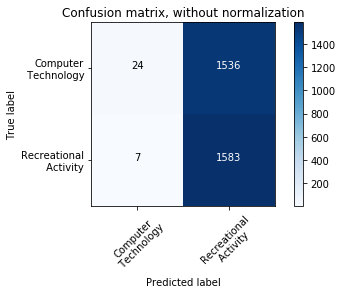

In [16]:
print('SVM using LSI')
fpr,tpr = predict_calculate_svc(lsi_train, lsi_test, binary_train_target, binary_test_target,gamma=1000)
fprs.append(fpr)
tprs.append(tpr)

SVM using LSI
gamma: 0.0001
Accuracy: 0.5047619047619047
Precision: 0.5047619047619047
Recall: 1.0
F-1 Score: 0.6708860759493671
Confusion matrix, without normalization
[[   0 1560]
 [   0 1590]]


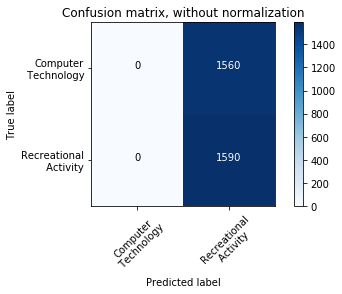

In [17]:
print('SVM using LSI')
fpr,tpr = predict_calculate_svc(lsi_train, lsi_test, binary_train_target, binary_test_target,gamma=0.0001)
fprs.append(fpr)
tprs.append(tpr)

SVM using NMF
gamma: 1000
Accuracy: 0.8803174603174603
Precision: 0.9549887471867967
Recall: 0.8006289308176101
F-1 Score: 0.8710229216558331
Confusion matrix, without normalization
[[1500   60]
 [ 317 1273]]


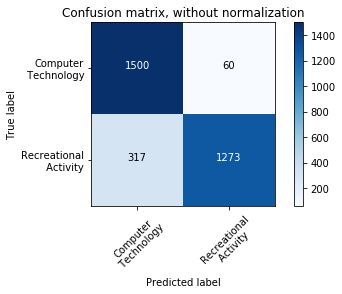

In [18]:
print('SVM using NMF')
fpr,tpr = predict_calculate_svc(nmf_train, nmf_test, binary_train_target, binary_test_target,gamma=1000)
fprs.append(fpr)
tprs.append(tpr)

SVM using NMF
gamma: 0.0001
Accuracy: 0.5047619047619047
Precision: 0.5047619047619047
Recall: 1.0
F-1 Score: 0.6708860759493671
Confusion matrix, without normalization
[[   0 1560]
 [   0 1590]]


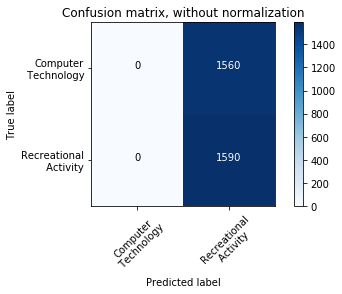

In [19]:
print('SVM using NMF')
fpr,tpr = predict_calculate_svc(nmf_train, nmf_test, binary_train_target, binary_test_target,gamma=0.0001)
fprs.append(fpr)
tprs.append(tpr)

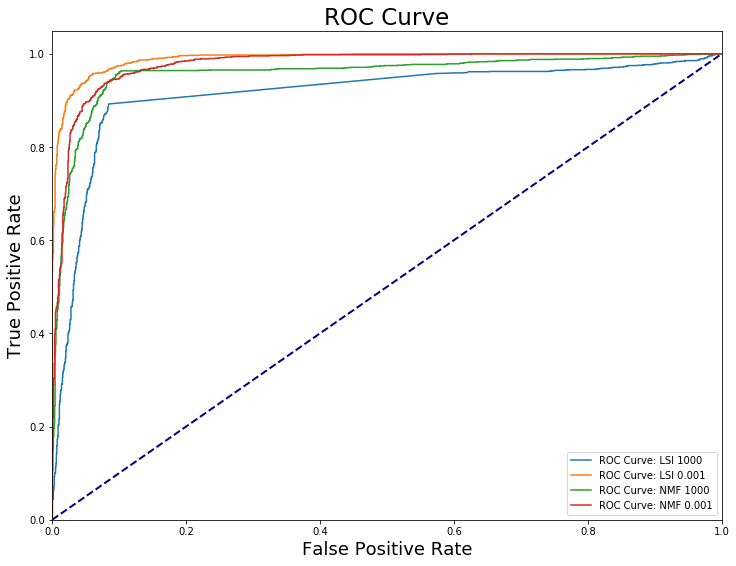

In [20]:
combined_roc_plotter(fprs, tprs, gammas=[1000, 0.001, 1000, 0.001], meths=['LSI', 'LSI', 'NMF', 'NMF'] )

# Optimize using 5-fold Validation

In [21]:
parameters = {'gamma':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
svm_cv = svm.SVC(probability = True)
svm_cv_grid = GridSearchCV(svm_cv, parameters, cv=5)
svm_cv_grid.fit(lsi_train, binary_train_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
pd.DataFrame(svm_cv_grid.cv_results_)[['param_gamma','mean_test_score']]

/Users/jennifermacdonald/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jennifermacdonald/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jennifermacdonald/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwarg

,param_gamma,mean_test_score
0,0.001,0.504861
1,0.01,0.883770
2,0.1,0.950338
3,1,0.957946
4,10,0.965554
5,100,0.852494
6,1000,0.524514


Based on 5-Fold cross validation, gamma=10 appears to be the best choice for LSI training set.

SVM using LSI
gamma: 10
Accuracy: 0.9498412698412698
Precision: 0.9360535931790499
Recall: 0.9666666666666667
F-1 Score: 0.9511138613861387
Confusion matrix, without normalization
[[1455  105]
 [  53 1537]]


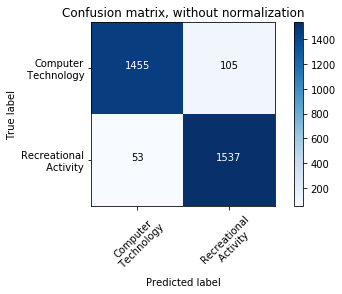

In [23]:
# Training an SVM with this optimized gamma parameter
print('SVM using LSI')
fpr,tpr = predict_calculate_svc(nmf_train, nmf_test, binary_train_target, binary_test_target,gamma=10)
fprs.append(fpr)
tprs.append(tpr)


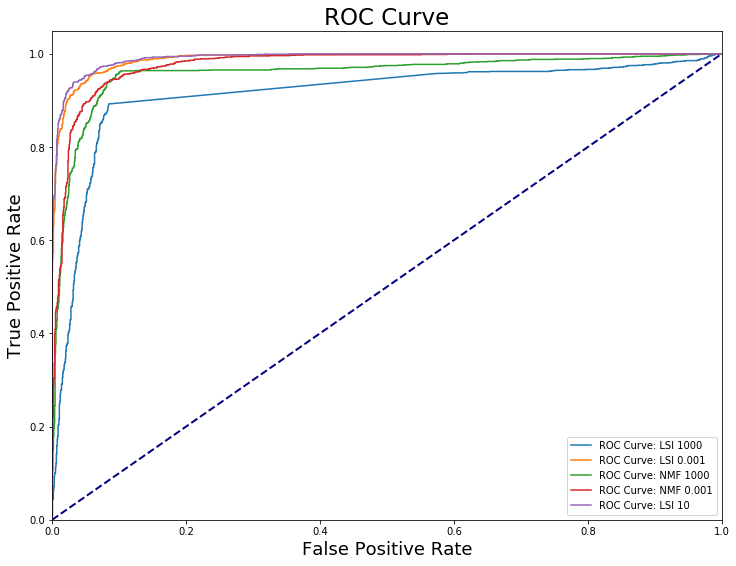

In [24]:
combined_roc_plotter(fprs, tprs, gammas=[1000, 0.001, 1000, 0.001, 10], meths=['LSI', 'LSI', 'NMF', 'NMF', 'LSI'] )

### QUESTION 5: Logistic classifier:
#### • Train a logistic classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier.
#### • Regularization:
##### – Using 5-fold cross-validation, find the best regularization strength in the range f10kj􀀀3  k  3; k 2 Zg for logistic regression with L1 regularization and logistic regression L2 regularization, respectively.
##### – Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization, using test data. How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?

# Logistic Regression Without Regularization (Very High C-value)

Logistic Regression (without regularization) Results: 

Accuracy:  0.9657142857142857
Recall:    0.969811320754717
Precision: 0.9625468164794008
f1:        0.9661654135338347

Confusion Matrix:
[[1500   60]
 [  48 1542]]


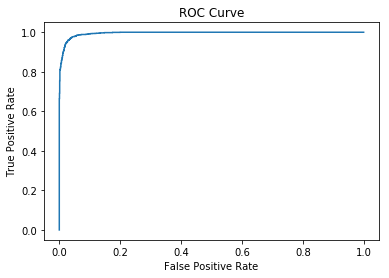

In [25]:
logistic = LogisticRegression(C=10**15) # ridiculously high C value to effectively have "no regularization"
logistic.fit(lsi_train, binary_train_target)
logistic_predictions = logistic.predict(lsi_test)
print("Logistic Regression (without regularization) Results: \n")
print("Accuracy:  " + str(metrics.accuracy_score(binary_test_target, logistic_predictions)))
print("Recall:    " + str(metrics.recall_score(binary_test_target,logistic_predictions)))
print("Precision: " + str(metrics.precision_score(binary_test_target,logistic_predictions)))
print("f1:        " + str(metrics.f1_score(binary_test_target,logistic_predictions)))
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(binary_test_target,logistic_predictions))

# Plot ROC Curve
roc_plotter(logistic,lsi_test,binary_test_target)

# Logistic Regression With L1 Regularization

In [26]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
logistic_l1 = LogisticRegression(penalty="l1")
logistic_l1_grid = GridSearchCV(logistic_l1, parameters,cv=5) #use logistic regression's default score()?
logistic_l1_grid.fit(lsi_train, binary_train_target)

pd.DataFrame(logistic_l1_grid.cv_results_)[['param_C','mean_test_score']]

/Users/jennifermacdonald/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jennifermacdonald/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jennifermacdonald/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwarg

,param_C,mean_test_score
0,0.001,0.495139
1,0.01,0.915892
2,0.1,0.933221
3,1,0.957312
4,10,0.966188
5,100,0.966188
6,1000,0.966822


# Logistic Regression With L2 Regularization

In [27]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
logistic_l2 = LogisticRegression(penalty="l2")
logistic_l2_grid = GridSearchCV(logistic_l2, parameters,cv=5) #use logistic regression's default score()?
logistic_l2_grid.fit(lsi_train, binary_train_target)

pd.DataFrame(logistic_l2_grid.cv_results_)[['param_C','mean_test_score']]

/Users/jennifermacdonald/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jennifermacdonald/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jennifermacdonald/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwarg

,param_C,mean_test_score
0,0.001,0.783601
1,0.01,0.924556
2,0.1,0.946746
3,1,0.955410
4,10,0.963018
5,100,0.964286
6,1000,0.966188


# Logistic Regression Analysis

Based on the cross-validation above, it seems that a C=10^3 leads to the highest validation mean accuracy. Thus, C = 1000 will be used in testing logistic regression classifiers in both L1 and L2 regularization methods.

In [28]:
# Without regularization
logistic = LogisticRegression(C=10**15) # ridiculously high C value to effectively have "no regularization"
logistic.fit(lsi_train, binary_train_target)
logistic_predictions = logistic.predict(lsi_test)
print("Logistic Regression (without regularization) Results: \n")
print("Accuracy:  " + str(metrics.accuracy_score(binary_test_target, logistic_predictions)))
print("Recall:    " + str(metrics.recall_score(binary_test_target,logistic_predictions)))
print("Precision: " + str(metrics.precision_score(binary_test_target,logistic_predictions)))
print("f1:        " + str(metrics.f1_score(binary_test_target,logistic_predictions)))

# With L1 regularization and C=1000
logistic_l1_c1000 = LogisticRegression(penalty='l1',C=10**3)
logistic_l1_c1000.fit(lsi_train, binary_train_target)
logistic_l1_c1000_predictions = logistic_l1_c1000.predict(lsi_test)
print("\nLogistic Regression (L1 regularization, C=1000) Results: \n")
print("Accuracy:  " + str(metrics.accuracy_score(binary_test_target, logistic_l1_c1000_predictions)))
print("Recall:    " + str(metrics.recall_score(binary_test_target,logistic_l1_c1000_predictions)))
print("Precision: " + str(metrics.precision_score(binary_test_target,logistic_l1_c1000_predictions)))
print("f1:        " + str(metrics.f1_score(binary_test_target,logistic_l1_c1000_predictions)))

# With L2 regularization and C=1000
logistic_l2_c1000 = LogisticRegression(penalty='l2',C=10**3)
logistic_l2_c1000.fit(lsi_train, binary_train_target)
logistic_l2_c1000_predictions = logistic_l2_c1000.predict(lsi_test)
print("\nLogistic Regression (L2 regularization, C=1000) Results: \n")
print("Accuracy:  " + str(metrics.accuracy_score(binary_test_target, logistic_l2_c1000_predictions)))
print("Recall:    " + str(metrics.recall_score(binary_test_target,logistic_l2_c1000_predictions)))
print("Precision: " + str(metrics.precision_score(binary_test_target,logistic_l2_c1000_predictions)))
print("f1:        " + str(metrics.f1_score(binary_test_target,logistic_l2_c1000_predictions)))

Logistic Regression (without regularization) Results: 

Accuracy:  0.9657142857142857
Recall:    0.969811320754717
Precision: 0.9625468164794008
f1:        0.9661654135338347

Logistic Regression (L1 regularization, C=1000) Results: 

Accuracy:  0.9657142857142857
Recall:    0.969811320754717
Precision: 0.9625468164794008
f1:        0.9661654135338347

Logistic Regression (L2 regularization, C=1000) Results: 

Accuracy:  0.9653968253968254
Recall:    0.9691823899371069
Precision: 0.962523422860712
f1:        0.9658414290191163


#### When numbers are finalized, have some blurb here comparing the above results (the numbers don't feel correct.. cross validation favors high C aka little regularization...but in test data that doesn't translate (accuracy is significantly higher when C = 1 compared to C = 1000 for test data... why is the cross validation not catching this? is the test data significantly different from the training data? maybe something's wrong with how i'm analyzing? bug in the data cleaning itself?))

In [29]:
print("Coefficient Statistics")
print("'Without' Regularization:       mean = %f, std = %f" % (np.mean(logistic.coef_), np.std(logistic.coef_)))
print("With L1, C=1000 Regularization: mean = %f, std = %f" % (np.mean(logistic_l1_c1000.coef_), np.std(logistic_l1_c1000.coef_)))
print("With L2, C=1000 Regularization: mean = %f, std = %f" % (np.mean(logistic_l2_c1000.coef_), np.std(logistic_l2_c1000.coef_)))

Coefficient Statistics
'Without' Regularization:       mean = 4.972139, std = 21.309671
With L1, C=1000 Regularization: mean = 4.966982, std = 21.235345
With L2, C=1000 Regularization: mean = 4.708639, std = 19.724925


# Naive Bayes Classifier

### QUESTION 6: Naïve Bayes classifier: train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier.

In [30]:
fprs = []
tprs = []

Naive Bayes using LSI
Accuracy: 0.7968253968253968
Precision: 0.7253320683111955
Recall: 0.9616352201257862
F-1 Score: 0.8269334775554354
Confusion matrix, without normalization
[[ 981  579]
 [  61 1529]]


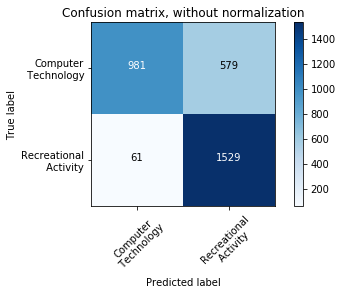

In [31]:
print('Naive Bayes using LSI')
fpr,tpr = predict_calculate_naive_bayes(lsi_train, lsi_test, binary_train_target, binary_test_target)
fprs.append(fpr)
tprs.append(tpr)

Naive Bayes using NMF
Accuracy: 0.9368253968253968
Precision: 0.909358446144791
Recall: 0.9716981132075472
F-1 Score: 0.9394952873213742
Confusion matrix, without normalization
[[1406  154]
 [  45 1545]]


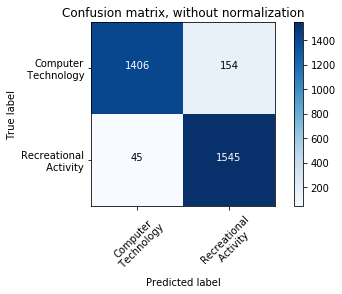

In [32]:
print('Naive Bayes using NMF')
fpr,tpr = predict_calculate_naive_bayes(nmf_train, nmf_test, binary_train_target, binary_test_target)
fprs.append(fpr)
tprs.append(tpr)

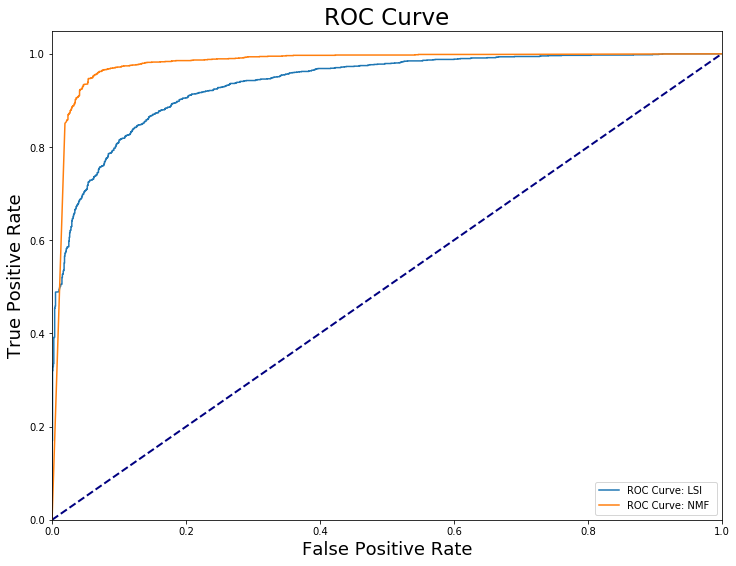

In [34]:
combined_roc_plotter(fprs, tprs, gammas=['', ''], meths=['LSI', 'NMF'] )

### QUESTION 7: Grid search of parameters:
#### • Construct a Pipeline that performs feature extraction, dimensionality reduction and classification;
#### • Do grid search with 5-fold cross-validation to compare the following (use test accuracy as the score to compare):

### QUESTION 8: In this part, we aim to learn classifiers on the documents belonging to the classes: comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, misc.forsale, soc.religion.christian. Perform Naïve Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers.